In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

 ## Load all files

In [3]:
#Load Dataset
file_path = 'CommercialOfficeRental.csv'
office_df = pd.read_csv(file_path)
office_df.head()

,Location,Building Class,Floor Area (SQM),25th Percentile ($ PSM),Median ($PSM),75th Percentile ($PSM),Reference Period
0,Central Area,Category 1,100 & Below,105.34,115.30,125.58,2025Q2
1,Central Area,Category 1,>100 - 200,106.57,121.47,144.77,2025Q2
2,Central Area,Category 1,>200 - 500,107.64,121.63,143.16,2025Q2
3,Central Area,Category 1,>500 - 1000,106.83,113.98,139.39,2025Q2
4,Central Area,Category 1,>1000,100.11,126.22,138.86,2025Q2


In [4]:
file_path = 'CommercialRetailRental.csv'
retail_df = pd.read_csv(file_path)
retail_df.head()

,Postal District,Floor Level,Floor Area (SQM),25th Percentile ($ PSM),Median ($PSM),75th Percentile ($PSM),Reference Period
0,1,B1 & Below,30 & Below,69.89,70.20,112.70,2021Q1
1,1,B1 & Below,>30 - 100,65.45,87.61,98.41,2021Q1
2,1,B1 & Below,>100 - 300,50.33,57.70,87.20,2021Q1
3,1,Level 1,30 & Below,87.36,123.94,222.00,2021Q1
4,1,Level 1,>30 - 100,75.26,109.37,147.04,2021Q1


In [5]:
# Load geographic datasets
postal_codes = pd.read_csv('SG_postal.csv')
city_coordinates = pd.read_csv('singapore_city_coordinates_improved.csv')
street_coordinates = pd.read_csv('street_coordinates.csv')
train_stations = pd.read_csv('mrt_lrt_data.csv')
postal_district_mapping = pd.read_csv('sg_postal_districts.csv')

print("Dataset Overview:")
print(f"Postal codes: {postal_codes.shape}")
print(f"City coordinates: {city_coordinates.shape}")
print(f"Street coordinates: {street_coordinates.shape}")
print(f"Train stations: {train_stations.shape}")
print(f"Postal district mapping: {postal_district_mapping.shape}")


missing_counts = city_coordinates.isnull().sum(axis=1)
print("Missing counts per row:\n", missing_counts)

missing_counts = city_coordinates.isna().sum(axis=1)  # Count missing values per row
city_coordinates.drop(city_coordinates[missing_counts >= 4].index, inplace=True)

Dataset Overview:
Postal codes: (121154, 4)
City coordinates: (332, 9)
Street coordinates: (589, 3)
Train stations: (209, 4)
Postal district mapping: (28, 3)
Missing counts per row:
 0      0
1      0
2      0
3      0
4      0
      ..
327    0
328    0
329    0
330    6
331    0
Length: 332, dtype: int64


## Add geo data to df

In [7]:
def add_geographic_features_summary(main_df, postal_df, street_df, city_df, stations_df, district_df, dataset_type='office'):
    """Enrich summary real estate data with geographic features including Postal District and Location"""
    
    df_enriched = main_df.copy()
    original_count = len(df_enriched)
    
    print(f"Adding geographic features to {dataset_type.upper()} summary data ({original_count} rows)...")
    
    # --- STRATEGY 1: ENSURE POSTAL DISTRICT FEATURE ---
    
    # For Office data: Create Postal District from Location if not present
    if dataset_type == 'office' and 'Postal District' not in df_enriched.columns:
        print("Creating Postal District feature for office data...")
        
        # Map office locations to approximate postal districts
        location_to_district = {
            'Central Area': '1',  # Raffles Place
            'Central Area Category 1': '1',
            'Central Area Category 2': '2',
            'Fringe Area': '3',  # Queenstown
            'Outside Central Area': '5'  # Pasir Panjang
        }
        
        if 'Location' in df_enriched.columns:
            def location_to_postal_district(location):
                if pd.isna(location): return np.nan
                location_clean = str(location).strip()
                for key, district in location_to_district.items():
                    if key in location_clean:
                        return district
                return np.nan
            
            df_enriched['Postal District'] = df_enriched['Location'].apply(location_to_postal_district)
            print(f"Created Postal District for {df_enriched['Postal District'].notna().sum()} office rows")
    
    # For Retail data: Ensure Postal District is properly formatted
    elif dataset_type == 'retail' and 'Postal District' in df_enriched.columns:
        print("Ensuring Postal District format for retail data...")
        df_enriched['Postal District'] = df_enriched['Postal District'].apply(
            lambda x: str(int(x)) if pd.notna(x) else np.nan
        )
    
    # --- STRATEGY 2: ENSURE LOCATION FEATURE ---
    
    # For Retail data: Create Location from Postal District if not present
    if dataset_type == 'retail' and 'Location' not in df_enriched.columns:
        print("Creating Location feature for retail data...")
        
        if 'Postal District' in df_enriched.columns:
            # Create a mapping from district to general location
            district_df['Postal District'] = district_df['Postal District'].astype(str)
            district_to_location = district_df.set_index('Postal District')['General Location'].to_dict()
            
            def postal_to_location(postal_district):
                if pd.isna(postal_district): return np.nan
                district_str = str(int(float(postal_district))) if '.' in str(postal_district) else str(postal_district)
                return district_to_location.get(district_str, 'Unknown')
            
            df_enriched['Location'] = df_enriched['Postal District'].apply(postal_to_location)
            print(f"Created Location for {df_enriched['Location'].notna().sum()} retail rows")
    
    # For Office data: Ensure Location is properly formatted
    elif dataset_type == 'office' and 'Location' in df_enriched.columns:
        print("Ensuring Location format for office data...")
        df_enriched['Location'] = df_enriched['Location'].astype(str)
    
    # --- STRATEGY 3: COORDINATES BASED ON AVAILABLE DATA ---
    
    # Create proper postal district string for both datasets
    if 'Postal District' in df_enriched.columns:
        df_enriched['Postal_District_Str'] = df_enriched['Postal District'].apply(
            lambda x: str(int(float(x))) if pd.notna(x) and str(x).replace('.','').isdigit() else 'Unknown'
        )
    
    # Get coordinates from postal districts
    if 'Postal_District_Str' in df_enriched.columns and 'postal_code' in postal_df.columns:
        print("Adding coordinates from postal districts...")
        
        postal_df['Postal District'] = postal_df['postal_code'].astype(str).str[:2]
        district_coords = postal_df.groupby('Postal District').agg({
            'lat': 'mean',
            'lon': 'mean'
        }).reset_index()
        
        df_enriched = df_enriched.merge(
            district_coords.rename(columns={'lat': 'latitude', 'lon': 'longitude'}),
            left_on='Postal_District_Str', right_on='Postal District', how='left'
        )
        
        coord_matches = df_enriched['latitude'].notna().sum()
        print(f"Added coordinates: {coord_matches} rows")
    
    # --- STRATEGY 4: ADD GENERAL LOCATION FROM DISTRICT MAPPING ---
    
    if 'Postal_District_Str' in df_enriched.columns:
        district_df['Postal District'] = district_df['Postal District'].astype(str)
        
        df_enriched = df_enriched.merge(
            district_df[['Postal District', 'General Location']].rename(columns={'General Location': 'General_Location'}),
            left_on='Postal_District_Str', right_on='Postal District', how='left',
            suffixes=('', '_from_district')
        )
        print(f"Added general location: {df_enriched['General_Location'].notna().sum()} rows")
    
    # --- STRATEGY 5: REGION CLASSIFICATION ---
    
    
    # --- STRATEGY 6: MRT DISTANCES ---
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        """Calculate Haversine distance between two points in kilometers"""
        R = 6371  # Earth radius in kilometers
        
        lat1_rad = np.radians(lat1)
        lon1_rad = np.radians(lon1)
        lat2_rad = np.radians(lat2)
        lon2_rad = np.radians(lon2)
        
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        return R * c
    
    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        station_coords = stations_df[['Latitude', 'Longitude']].dropna()
        
        if len(valid_coords) > 0 and len(station_coords) > 0:
            print(f"Calculating MRT distances for {len(valid_coords)} rows...")
            
            min_dists = []
            for idx, prop_row in valid_coords.iterrows():
                prop_lat, prop_lon = prop_row['latitude'], prop_row['longitude']
                
                distances = []
                for _, station_row in station_coords.iterrows():
                    dist = haversine_distance(
                        prop_lat, prop_lon,
                        station_row['Latitude'], station_row['Longitude']
                    )
                    distances.append(dist)
                
                min_dists.append(min(distances) if distances else np.nan)
            
            df_enriched.loc[valid_coords.index, 'Distance_to_MRT_km'] = min_dists
            print(f"Added MRT distances: {len([x for x in min_dists if not np.isnan(x)])} rows")
    
    # --- STRATEGY 7: URBAN CLASSIFICATION ---
    
    # CBD proximity (distance to Raffles Place)
    cbd_coords = (1.2833, 103.8515)  # Raffles Place
    if all(col in df_enriched.columns for col in ['latitude', 'longitude']):
        valid_coords = df_enriched[['latitude', 'longitude']].dropna()
        if len(valid_coords) > 0:
            cbd_distances = []
            for idx, row in valid_coords.iterrows():
                dist = haversine_distance(
                    row['latitude'], row['longitude'],
                    cbd_coords[0], cbd_coords[1]
                )
                cbd_distances.append(dist)
            
            df_enriched.loc[valid_coords.index, 'Distance_to_CBD_km'] = cbd_distances
    
    def classify_urban_rural(distance_to_cbd):
        if pd.isna(distance_to_cbd): return 'Unknown'
        if distance_to_cbd <= 5: return 'CBD'
        elif distance_to_cbd <= 10: return 'Urban'
        elif distance_to_cbd <= 20: return 'Suburban'
        else: return 'Rural'
    
    if 'Distance_to_CBD_km' in df_enriched.columns:
        df_enriched['Urban_Classification'] = df_enriched['Distance_to_CBD_km'].apply(classify_urban_rural)
        print(f"Added urban classification")
    
    # --- FINAL FEATURE CONSOLIDATION ---
    
    # Ensure both datasets have consistent feature names
    print("\nFinal feature consolidation...")
    
    # List of expected geographic features
    expected_geo_features = [
        'Postal District', 'Location', 'General_Location', 
        'Region_Classification', 'Urban_Classification',
        'latitude', 'longitude', 'Distance_to_MRT_km', 'Distance_to_CBD_km'
    ]
    
    # Add missing features as NaN columns
    for feature in expected_geo_features:
        if feature not in df_enriched.columns:
            df_enriched[feature] = np.nan
            print(f"  Added missing feature: {feature}")
    
    # --- FINAL REPORT ---
    print("\n" + "="*60)
    print(f"GEOGRAPHIC FEATURE ENGINEERING COMPLETE - {dataset_type.upper()}")
    print("="*60)
    
    print("CORE FEATURES ADDED:")
    print(f"  • Postal District: {df_enriched['Postal District'].notna().sum()}/{original_count}")
    print(f"  • Location: {df_enriched['Location'].notna().sum()}/{original_count}")
    print(f"  • General Location: {df_enriched['General_Location'].notna().sum()}/{original_count}")
    
    print("\nGEOGRAPHIC FEATURES:")
    if 'latitude' in df_enriched.columns:
        print(f"  • Coordinates: {df_enriched['latitude'].notna().sum()}/{original_count}")
    if 'Distance_to_MRT_km' in df_enriched.columns:
        print(f"  • MRT Distances: {df_enriched['Distance_to_MRT_km'].notna().sum()}/{original_count}")
    # if 'Region_Classification' in df_enriched.columns:
    #     print(f"  • Region Classification: {(df_enriched['Region_Classification'] != 'Unknown').sum()}/{original_count}")
    if 'Urban_Classification' in df_enriched.columns:
        print(f"  • Urban Classification: {(df_enriched['Urban_Classification'] != 'Unknown').sum()}/{original_count}")
    
    # Show sample of added features
    print(f"\nSAMPLE OF ADDED FEATURES:")
    sample_cols = [col for col in df_enriched.columns if any(x in col.lower() for x in ['postal', 'location', 'region', 'urban'])]
    if sample_cols:
        print(df_enriched[sample_cols].head(3))
    
    # Clean up temporary columns
    cols_to_drop = [col for col in df_enriched.columns if col in ['Postal_District_Str', 'Postal District_from_district', 'Postal District_y']]
    df_enriched = df_enriched.drop(columns=cols_to_drop, errors='ignore')
    
    return df_enriched

# Apply to both datasets
print("PROCESSING OFFICE AND RETAIL DATA WITH POSTAL DISTRICT & LOCATION FEATURES")
print("=" * 70)

print("\n" + "="*40)
print("PROCESSING OFFICE DATA")
print("="*40)
office_enriched = add_geographic_features_summary(
    office_df, 
    postal_codes, 
    street_coordinates, 
    city_coordinates, 
    train_stations, 
    postal_district_mapping,
    dataset_type='office'
)

print("\n" + "="*40)
print("PROCESSING RETAIL DATA")
print("="*40)
retail_enriched = add_geographic_features_summary(
    retail_df, 
    postal_codes, 
    street_coordinates, 
    city_coordinates, 
    train_stations, 
    postal_district_mapping,
    dataset_type='retail'
)

print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"OFFICE DATA - Final shape: {office_enriched.shape}")
print(f"RETAIL DATA - Final shape: {retail_enriched.shape}")

# Show the key features that were added to both datasets
print(f"\nKEY FEATURES IN BOTH DATASETS:")
common_geo_features = [col for col in office_enriched.columns if col in retail_enriched.columns and any(x in col.lower() for x in ['postal', 'location', 'region', 'urban'])]

for feature in common_geo_features:
    office_non_null = office_enriched[feature].notna().sum()
    retail_non_null = retail_enriched[feature].notna().sum()
    print(f"  {feature:25} | Office: {office_non_null:3} | Retail: {retail_non_null:3}")

print(f"\n BOTH DATASETS NOW HAVE POSTAL DISTRICT AND LOCATION FEATURES!")
print(f" READY FOR FURTHER ANALYSIS OR MODELING!")

PROCESSING OFFICE AND RETAIL DATA WITH POSTAL DISTRICT & LOCATION FEATURES

PROCESSING OFFICE DATA
Adding geographic features to OFFICE summary data (356 rows)...
Creating Postal District feature for office data...
Created Postal District for 268 office rows
Ensuring Location format for office data...
Adding coordinates from postal districts...
Added coordinates: 0 rows
Added general location: 268 rows

Final feature consolidation...
  Added missing feature: Region_Classification
  Added missing feature: Urban_Classification
  Added missing feature: Distance_to_MRT_km
  Added missing feature: Distance_to_CBD_km

GEOGRAPHIC FEATURE ENGINEERING COMPLETE - OFFICE
CORE FEATURES ADDED:
  • Postal District: 268/356
  • Location: 356/356
  • General Location: 268/356

GEOGRAPHIC FEATURES:
  • Coordinates: 0/356
  • MRT Distances: 0/356
  • Urban Classification: 356/356

SAMPLE OF ADDED FEATURES:
       Location Postal District_x Postal_District_Str Postal District_y  \
0  Central Area        

## merge both dfs

In [9]:
def clean_and_merge_datasets(office_enriched, retail_enriched):
    """Clean and merge office and retail datasets with robust column handling"""
    
    print("CLEANING AND MERGING OFFICE & RETAIL DATASETS")
    print("=" * 60)
    
    # Create copies to avoid modifying originals
    office_clean = office_enriched.copy()
    retail_clean = retail_enriched.copy()
    
    # 1. FIRST, LET'S SEE WHAT COLUMNS WE ACTUALLY HAVE
    print("1. Checking available columns...")
    print(f"   Office columns: {list(office_clean.columns)}")
    print(f"   Retail columns: {list(retail_clean.columns)}")
    
    # 2. HANDLE DUPLICATE AND MISSING COLUMNS
    print("\n2. Handling column inconsistencies...")
    
    # Create consistent column names first
    column_standardization = {
        # Price columns (handle different naming patterns)
        '25th Percentile ($ PSM)': 'Percentile_25_PSM',
        '25th Percentile ($ PSM) ': 'Percentile_25_PSM',  # Extra space
        'Median ($PSM)': 'Median_PSM',
        'Median ($PSM) ': 'Median_PSM',
        '75th Percentile ($ PSM)': 'Percentile_75_PSM', 
        '75th Percentile ($ PSM) ': 'Percentile_75_PSM',
        
        # Other columns
        'Reference Period': 'Reference_Period',
        'Floor Area (SQM)': 'Floor_Area_SQM',
        'Building Class': 'Building_Class',
        'Floor Level': 'Floor_Level'
    }
    
    # Apply renaming to both datasets
    office_clean = office_clean.rename(columns=column_standardization)
    retail_clean = retail_clean.rename(columns=column_standardization)
    
    print(f"   Office columns after renaming: {list(office_clean.columns)}")
    print(f"   Retail columns after renaming: {list(retail_clean.columns)}")
    
    # 3. HANDLE POSTAL DISTRICT DUPLICATES
    print("\n3. Handling Postal District columns...")
    
    def handle_postal_district(df, dataset_name):
        postal_cols = [col for col in df.columns if 'Postal District' in col]
        if len(postal_cols) > 1:
            print(f"   {dataset_name}: Found multiple Postal District columns: {postal_cols}")
            # Use the one with more non-null values
            non_null_counts = {col: df[col].notna().sum() for col in postal_cols}
            best_col = max(non_null_counts, key=non_null_counts.get)
            print(f"   Using '{best_col}' with {non_null_counts[best_col]} non-null values")
            
            # Create final postal district column
            df['Postal_District_Final'] = df[best_col]
            
            # Drop the original postal district columns
            df = df.drop(postal_cols, axis=1)
            df = df.drop('Region_Classification', axis=1)
            df = df.drop('Urban_Classification', axis=1)
            
        elif len(postal_cols) == 1:
            df['Postal_District_Final'] = df[postal_cols[0]]
            df = df.drop(postal_cols, axis=1)
        else:
            df['Postal_District_Final'] = np.nan
            print(f"   {dataset_name}: No Postal District columns found")
        
        return df
    
    office_clean = handle_postal_district(office_clean, 'Office')
    retail_clean = handle_postal_district(retail_clean, 'Retail')
    
    # 4. ADD PROPERTY TYPE IDENTIFIER
    print("\n4. Adding property type identifiers...")
    office_clean['Property_Type'] = 'Office'
    retail_clean['Property_Type'] = 'Retail'
    
    # 5. CREATE FLEXIBLE COMMON COLUMNS LIST
    print("\n5. Creating flexible column selection...")
    
    # Define all possible columns we might want
    all_possible_columns = [
        'Property_Type', 'Location', 'Postal_District_Final', 'General_Location',
        'Region_Classification', 'Urban_Classification', 'Floor_Area_SQM',
        'Percentile_25_PSM', 'Median_PSM', 'Percentile_75_PSM', 'Reference_Period',
        'latitude', 'longitude', 'Distance_to_MRT_km', 'Distance_to_CBD_km',
        'Building_Class', 'Floor_Level'
    ]
    
    # Only select columns that actually exist in each dataset
    def get_available_columns(df, possible_columns):
        return [col for col in possible_columns if col in df.columns]
    
    office_columns = get_available_columns(office_clean, all_possible_columns)
    retail_columns = get_available_columns(retail_clean, all_possible_columns)
    
    print(f"   Office available columns: {len(office_columns)}")
    print(f"   Retail available columns: {len(retail_columns)}")
    
    # 6. HANDLE MISSING GEOGRAPHIC DATA
    print("\n6. Handling missing geographic data...")
    
    def fill_missing_geo_data(df, property_type):
        df_filled = df.copy()
        
        # Fill missing coordinates
        if 'latitude' in df_filled.columns:
            missing_coords = df_filled['latitude'].isna().sum()
            if missing_coords > 0:
                print(f"   {property_type}: Filling {missing_coords} missing coordinates")
                
                if property_type == 'Office':
                    default_coords = (1.280, 103.850)  # Raffles Place
                else:  # Retail
                    default_coords = (1.352, 103.819)  # Regional center
                
                df_filled['latitude'] = df_filled['latitude'].fillna(default_coords[0])
                df_filled['longitude'] = df_filled['longitude'].fillna(default_coords[1])
        
        # Fill missing distances with reasonable estimates
        if 'Distance_to_MRT_km' in df_filled.columns:
            missing_mrt = df_filled['Distance_to_MRT_km'].isna().sum()
            if missing_mrt > 0:
                df_filled['Distance_to_MRT_km'] = df_filled['Distance_to_MRT_km'].fillna(2.0)
        
        if 'Distance_to_CBD_km' in df_filled.columns:
            missing_cbd = df_filled['Distance_to_CBD_km'].isna().sum()
            if missing_cbd > 0:
                default_cbd = 3.0 if property_type == 'Office' else 6.0
                df_filled['Distance_to_CBD_km'] = df_filled['Distance_to_CBD_km'].fillna(default_cbd)
        
        return df_filled
    
    office_clean = fill_missing_geo_data(office_clean, 'Office')
    retail_clean = fill_missing_geo_data(retail_clean, 'Retail')
    
    # 7. SELECT FINAL COLUMNS AND MERGE
    print("\n7. Selecting final columns and merging...")
    
    # Get intersection of columns that exist in both datasets
    common_columns = list(set(office_columns) & set(retail_columns))
    print(f"   Common columns: {common_columns}")
    
    # Select only common columns for merging
    office_final = office_clean[common_columns].copy()
    retail_final = retail_clean[common_columns].copy()
    
    # Merge datasets
    merged_df = pd.concat([office_final, retail_final], axis=0, ignore_index=True)
    
    print(f"   Office final: {len(office_final)} rows, {len(office_final.columns)} columns")
    print(f"   Retail final: {len(retail_final)} rows, {len(retail_final.columns)} columns")
    print(f"   Merged total: {len(merged_df)} rows, {len(merged_df.columns)} columns")
    
    return merged_df, office_final, retail_final

def analyze_merged_dataset(merged_df):
    """Analyze the merged dataset"""
    
    print("\n" + "=" * 60)
    print("MERGED DATASET ANALYSIS")
    print("=" * 60)
    
    if merged_df.empty:
        print(" Merged dataset is empty!")
        return None
    
    print(f"Total properties: {len(merged_df)}")
    print(f"Office properties: {(merged_df['Property_Type'] == 'Office').sum()}")
    print(f"Retail properties: {(merged_df['Property_Type'] == 'Retail').sum()}")
    
    print(f"\nDataset shape: {merged_df.shape}")
    print(f"Columns: {list(merged_df.columns)}")
    
    # Check for missing values
    print(f"\nMISSING VALUES SUMMARY:")
    missing_data = merged_df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        for col, count in missing_data.items():
            percentage = (count / len(merged_df)) * 100
            print(f"  {col}: {count} missing ({percentage:.1f}%)")
    else:
        print("  No missing values!")
    
    # Basic statistics
    if 'Median_PSM' in merged_df.columns:
        print(f"\nPRICE STATISTICS (Median PSM):")
        stats = merged_df.groupby('Property_Type')['Median_PSM'].describe()
        print(stats)
    
    return merged_df

def save_datasets(merged_df, office_final, retail_final):
    """Save the cleaned datasets"""
    
    print("\n" + "=" * 60)
    print("SAVING DATASETS")
    print("=" * 60)
    
    try:
        # Save merged dataset
        merged_filename = 'office_retail_merged.csv'
        merged_df.to_csv(merged_filename, index=False)
        print(f" Merged dataset saved: {merged_filename}")
        
        # Save individual datasets
        office_filename = 'office_cleaned.csv'
        retail_filename = 'retail_cleaned.csv'
        
        office_final.to_csv(office_filename, index=False)
        retail_final.to_csv(retail_filename, index=False)
        
        print(f"Office dataset saved: {office_filename}")
        print(f" Retail dataset saved: {retail_filename}")
        
        return merged_filename, office_filename, retail_filename
        
    except Exception as e:
        print(f" Error saving files: {e}")
        return None, None, None
try:
    # 1. Clean and merge
    merged_df, office_final, retail_final = clean_and_merge_datasets(office_enriched, retail_enriched)
    
    # 2. Analyze the merged dataset
    analysis_result = analyze_merged_dataset(merged_df)
    
    # 3. Save the results
    if not merged_df.empty:
        merged_file, office_file, retail_file = save_datasets(merged_df, office_final, retail_final)
        
        print("\n" + "=" * 70)
        print(" CLEANING AND MERGING COMPLETED SUCCESSFULLY!")
        print("=" * 70)
        print(f" FINAL DATASET: {len(merged_df)} total properties")
        print(f" Office: {(merged_df['Property_Type'] == 'Office').sum()} properties") 
        print(f"  Retail: {(merged_df['Property_Type'] == 'Retail').sum()} properties")
        
        # Show sample
        print(f"\nSAMPLE OF MERGED DATA:")
        sample_cols = ['Property_Type', 'Location', 'Median_PSM', 'Region_Classification']
        available_sample_cols = [col for col in sample_cols if col in merged_df.columns]
        print(merged_df[available_sample_cols].head(8))
        
    else:
        print(" No data to save - merged dataset is empty")

except Exception as e:
    print(f"Error during processing: {e}")
    print("Trying alternative approach...")


CLEANING AND MERGING OFFICE & RETAIL DATASETS
1. Checking available columns...
   Office columns: ['Location', 'Building Class', 'Floor Area (SQM)', '25th Percentile ($ PSM)', 'Median ($PSM)', '75th Percentile ($PSM)', 'Reference Period', 'Postal District_x', 'latitude', 'longitude', 'Postal District', 'General_Location', 'Region_Classification', 'Urban_Classification', 'Distance_to_MRT_km', 'Distance_to_CBD_km']
   Retail columns: ['Postal District_x', 'Floor Level', 'Floor Area (SQM)', '25th Percentile ($ PSM)', 'Median ($PSM)', '75th Percentile ($PSM)', 'Reference Period', 'Location', 'latitude', 'longitude', 'Postal District', 'General_Location', 'Distance_to_MRT_km', 'Distance_to_CBD_km', 'Urban_Classification', 'Region_Classification']

2. Handling column inconsistencies...
   Office columns after renaming: ['Location', 'Building_Class', 'Floor_Area_SQM', 'Percentile_25_PSM', 'Median_PSM', '75th Percentile ($PSM)', 'Reference_Period', 'Postal District_x', 'latitude', 'longitude',

In [10]:
def fix_data_issues(merged_df):
    """Fix issues in the merged dataset before modeling"""
    
    df_fixed = merged_df.copy()
    
    print("FIXING DATA ISSUES:")
    print("=" * 50)
    
    # 1. Fix Floor_Area_SQM - it's currently text ranges, not numbers
    print("1. Converting Floor_Area_SQM from text to numeric...")
    
    def parse_floor_area(area_text):
        if pd.isna(area_text):
            return np.nan
        text = str(area_text).lower()
        
        if 'below' in text or '& below' in text:
            return 50  # Assume average of small units
        elif '>' in text and '-' in text:
            # Extract numbers from ranges like ">100 - 200"
            numbers = [int(s) for s in text.split() if s.isdigit()]
            if len(numbers) == 2:
                return (numbers[0] + numbers[1]) / 2  # Return midpoint
        elif '>' in text:
            # For ">1000", return a reasonable large value
            numbers = [int(s) for s in text.split() if s.isdigit()]
            if numbers:
                return numbers[0] * 1.5  # 50% above the threshold
        
        return np.nan
    
    df_fixed['Floor_Area_SQM_Numeric'] = df_fixed['Floor_Area_SQM'].apply(parse_floor_area)
    print(f"   Converted {df_fixed['Floor_Area_SQM_Numeric'].notna().sum()} area values")
    
    # 2. Create better features
    print("2. Creating enhanced features...")
    
    # Property type as numeric
    df_fixed['Property_Type_Code'] = df_fixed['Property_Type'].map({'Office': 1, 'Retail': 0})
    
    # Extract year and quarter from Reference_Period
    df_fixed['Year'] = df_fixed['Reference_Period'].str[:4].astype(int)
    df_fixed['Quarter'] = df_fixed['Reference_Period'].str[-1].astype(int)
    
    # Region classification as numeric
    region_mapping = {
        'Central Core': 4,
        'Rest Central': 3, 
        'City Fringe': 2,
        'Outside Central': 1,
        'Unknown': 0
    }
    # df_fixed['Region_Code'] = df_fixed['Region_Classification'].map(region_mapping)
    
    print(f"   Created {df_fixed.shape[1] - merged_df.shape[1]} new features")
    
    return df_fixed

# Prepare features for modeling
def prepare_modeling_features(df_fixed, target_column='Median_PSM'):
    """Prepare features for machine learning"""
    
    # Select numeric features for modeling
    feature_columns = [
        'Floor_Area_SQM_Numeric', 'Property_Type_Code', 'Region_Code',
        'Year', 'Quarter', 'Distance_to_MRT_km', 'Distance_to_CBD_km',
        'latitude', 'longitude'
    ]
    
    # Only use features that exist and have data
    available_features = [col for col in feature_columns if col in df_fixed.columns and df_fixed[col].notna().any()]
    
    X = df_fixed[available_features].fillna(df_fixed[available_features].median())
    y = df_fixed[target_column]
    
    print(f"FEATURES FOR MODELING:")
    print(f"  Target: {target_column}")
    print(f"  Features: {available_features}")
    print(f"  X shape: {X.shape}, y shape: {y.shape}")
    
    return X, y, available_features

# Execute the fixes
print("PREPARING DATA FOR MODELING")
print("=" * 60)

# Fix data issues
df_fixed = fix_data_issues(merged_df)

# Prepare features
X, y, feature_names = prepare_modeling_features(df_fixed, 'Median_PSM')


print(f" Target: Median_PSM (Price per Square Meter)")
print(f" Samples: {len(X)} properties")
print(f" Features: {len(feature_names)} numeric features")

PREPARING DATA FOR MODELING
FIXING DATA ISSUES:
1. Converting Floor_Area_SQM from text to numeric...
   Converted 1228 area values
2. Creating enhanced features...
   Created 4 new features
FEATURES FOR MODELING:
  Target: Median_PSM
  Features: ['Floor_Area_SQM_Numeric', 'Property_Type_Code', 'Year', 'Quarter', 'Distance_to_MRT_km', 'Distance_to_CBD_km', 'latitude', 'longitude']
  X shape: (4109, 8), y shape: (4109,)
 Target: Median_PSM (Price per Square Meter)
 Samples: 4109 properties
 Features: 8 numeric features


In [11]:
target_column='Median_PSM'

In [12]:
feature_columns = [col for col in merged_df.columns]
categorical_columns = merged_df[feature_columns].select_dtypes(include=['object', 'category']).columns
numerical_columns = merged_df[feature_columns].select_dtypes(include=[np.number]).columns

X_encoded = pd.get_dummies(merged_df[feature_columns], columns=categorical_columns, drop_first=True)
y = merged_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

In [13]:
# First, let's check what's actually in your target column
print("Checking target column data types:")
print(f"Target column: {target_column}")
print(f"Data type: {merged_df[target_column].dtype}")
print(f"Sample values:")
print(merged_df[target_column].head(10))
print(f"Unique values: {merged_df[target_column].unique()[:10]}")  # First 10 unique values

# Convert target column to numeric, handling any non-numeric values
def safe_numeric_conversion(series):
    """Safely convert series to numeric, handling errors"""
    # First try direct conversion
    converted = pd.to_numeric(series, errors='coerce')
    
    # Check if we have any non-numeric values
    non_numeric_count = series.size - converted.notna().sum()
    if non_numeric_count > 0:
        print(f"Found {non_numeric_count} non-numeric values in target column")
        print("Non-numeric values:")
        non_numeric_mask = pd.to_numeric(series, errors='coerce').isna()
        print(series[non_numeric_mask].unique())
    
    return converted

# Apply conversion
y_numeric = safe_numeric_conversion(merged_df[target_column])

print(f"\nAfter conversion:")
print(f"Target stats - Min: ${y_numeric.min():.2f}, Max: ${y_numeric.max():.2f}, Mean: ${y_numeric.mean():.2f}")
print(f"Missing values after conversion: {y_numeric.isna().sum()}")

# Remove rows where target is NaN after conversion
valid_mask = y_numeric.notna()
X_clean = X_encoded[valid_mask]
y_clean = y_numeric[valid_mask]

print(f"\nAfter cleaning:")
print(f"X_clean shape: {X_clean.shape}")
print(f"y_clean shape: {y_clean.shape}")

# Now proceed with train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTraining set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Create a simple baseline (predict mean) - THIS SHOULD WORK NOW
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"\nBaseline Model (Mean Prediction):")
print(f"MAE: ${baseline_mae:,.2f}")
print(f"RMSE: ${baseline_rmse:,.2f}")

# Now train a simple model to test
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

print(f"\nTraining Random Forest model...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model_mae = mean_absolute_error(y_test, y_pred)
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model_r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model:")
print(f"MAE: ${model_mae:,.2f}")
print(f"RMSE: ${model_rmse:,.2f}")
print(f"R²: {model_r2:.4f}")

# Compare with baseline
improvement = ((baseline_mae - model_mae) / baseline_mae) * 100
print(f"Improvement over baseline: {improvement:+.1f}%")

Checking target column data types:
Target column: Median_PSM
Data type: object
Sample values:
0     115.3
1    121.47
2    121.63
3    113.98
4    126.22
5     70.11
6     83.96
7     82.72
8     91.49
9     54.36
Name: Median_PSM, dtype: object
Unique values: [115.3 121.47 121.63 113.98 126.22 70.11 83.96 82.72 91.49 54.36]
Found 1 non-numeric values in target column
Non-numeric values:
['1,017.50']

After conversion:
Target stats - Min: $12.75, Max: $964.19, Mean: $151.35
Missing values after conversion: 1

After cleaning:
X_clean shape: (4108, 3675)
y_clean shape: (4108,)

Training set: (3286, 3675)
Testing set: (822, 3675)

Baseline Model (Mean Prediction):
MAE: $80.15
RMSE: $109.96

Training Random Forest model...
Random Forest Model:
MAE: $21.39
RMSE: $37.89
R²: 0.8812
Improvement over baseline: +73.3%


In [14]:

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
# Check for missing values
print("Missing values in features:")
print(X_encoded.isnull().sum().sum())
print("Missing values in target:")
print(y.isnull().sum())

# Handle missing values
def handle_missing_values(X, strategy='mean'):
    """Handle missing values in the feature matrix"""
    imputer = SimpleImputer(strategy=strategy)
    X_imputed = imputer.fit_transform(X)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Apply to training and test data
X_train_imputed = handle_missing_values(X_train)
X_test_imputed = handle_missing_values(X_test)

print(f"Missing values after imputation - Train: {X_train_imputed.isnull().sum().sum()}")
print(f"Missing values after imputation - Test: {X_test_imputed.isnull().sum().sum()}")

Missing values in features:
0
Missing values in target:
0
Missing values after imputation - Train: 0
Missing values after imputation - Test: 0


## Train model

In [16]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if y needs cleaning (only if it's string type)
if y.dtype == 'object':
    y = y.str.replace(',', '').astype(float)
else:
    print(f"y is already numeric (dtype: {y.dtype})")

# Check for NaN values
print(f"NaN values in y: {y.isna().sum()}")
print(f"NaN values in y_train: {y_train.isna().sum()}")

# Remove NaN values if any
if y.isna().sum() > 0:
    y = y.dropna()
    print(f"Removed NaN values from y")

if y_train.isna().sum() > 0:
    y_train = y_train.dropna()
    print(f"Removed NaN values from y_train")

# Convert feature data to numpy arrays to avoid XGBoost dtype issues
X_train_array = np.array(X_train_imputed)
X_test_array = np.array(X_test_imputed)

# Make sure y_train and y_test align with the feature arrays
# If you need to recreate splits to ensure alignment:
# X_train_array, X_test_array, y_train, y_test = train_test_split(
#     X_imputed, y, test_size=0.2, random_state=42
# )

# Models definition
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42, max_iter=100),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_seed=42, verbose=False, allow_writing_files=False)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        if name == 'CatBoost':
            # For CatBoost, use categorical features if available
            if 'categorical_columns' in locals() and 'feature_columns' in locals():
                cat_features_list = list(categorical_columns)
                X_cat = merged_df[feature_columns].copy()
                
                # Convert categorical columns to string for CatBoost
                for col in cat_features_list:
                    if col in X_cat.columns:
                        X_cat[col] = X_cat[col].astype(str)
                
                # Split for CatBoost
                X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
                    X_cat, y, test_size=0.2, random_state=42
                )
                
                # Remove NaN from CatBoost target
                nan_mask = ~y_train_cat.isna()
                X_train_cat = X_train_cat[nan_mask]
                y_train_cat = y_train_cat[nan_mask]
                
                # Identify categorical feature indices for CatBoost
                cat_features_indices = [i for i, col in enumerate(X_cat.columns) if col in cat_features_list]
                
                model.fit(X_train_cat, y_train_cat, cat_features=cat_features_indices)
                y_pred = model.predict(X_test_cat)
                y_test_compare = y_test_cat
            else:
                # Fallback: use numpy arrays if categorical features not defined
                model.fit(X_train_array, y_train)
                y_pred = model.predict(X_test_array)
                y_test_compare = y_test
            
        else:
            # Use numpy arrays for other models
            model.fit(X_train_array, y_train)
            y_pred = model.predict(X_test_array)
            y_test_compare = y_test
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_compare, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_compare, y_pred))
        r2 = r2_score(y_test_compare, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred,
            'y_test': y_test_compare
        }
        
        print(f"{name} Results:")
        print(f"  MAE: ${mae:,.2f}")
        print(f"  RMSE: ${rmse:,.2f}")
        print(f"  R²: {r2:.4f}")
        if 'baseline_mae' in locals():
            print(f"  Improvement over baseline: {((baseline_mae - mae) / baseline_mae * 100):.1f}%")
        
    except Exception as e:
        print(f"Error training {name}: {e}")
        continue

# Find best model
if results:
    best_model_name = min(results.keys(), key=lambda x: results[x]['mae'])
    best_model = results[best_model_name]['model']
    print(f"\nBest Model: {best_model_name}")
    print(f"Best MAE: ${results[best_model_name]['mae']:,.2f}")

NaN values in y: 356
NaN values in y_train: 0
Removed NaN values from y

Training Random Forest...
Random Forest Results:
  MAE: $21.39
  RMSE: $37.89
  R²: 0.8812
  Improvement over baseline: 73.3%

Training Hist Gradient Boosting...
Hist Gradient Boosting Results:
  MAE: $22.98
  RMSE: $37.02
  R²: 0.8866
  Improvement over baseline: 71.3%

Training XGBoost...
XGBoost Results:
  MAE: $22.45
  RMSE: $38.15
  R²: 0.8796
  Improvement over baseline: 72.0%

Training CatBoost...
Error training CatBoost: Found input variables with inconsistent numbers of samples: [4109, 3753]

Best Model: Random Forest
Best MAE: $21.39


In [22]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

def train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Enhanced model training with better validation and ensemble options"""
    
    print("Training enhanced models with improved configurations...")
    print("=" * 60)
    
    # Enhanced models with optimized hyperparameters
    models = {
        # 'Random Forest': RandomForestRegressor(
        #     n_estimators=200,
        #     max_depth=20,
        #     min_samples_split=10,
        #     min_samples_leaf=4,
        #     max_features='sqrt',
        #     bootstrap=True,
        #     random_state=42,
        #     n_jobs=-1
        # ),
        'Hist Gradient Boosting': HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=8,
            learning_rate=0.1,
            min_samples_leaf=20,
            l2_regularization=0.1,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    # Add CatBoost if you have categorical features
    try:
        models['CatBoost'] = CatBoostRegressor(
            iterations=200,
            depth=8,
            learning_rate=0.1,
            random_state=42,
            verbose=False
        )
    except:
        print("CatBoost not available, skipping...")
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_imputed, y_train)
            y_pred = model.predict(X_test_imputed)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation for robustness
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_imputed, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Store results
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test RMSE: ${rmse:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
            if baseline_mae:
                improvement = ((baseline_mae - mae) / baseline_mae * 100)
                print(f"Improvement over baseline: {improvement:+.1f}%")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test):
    """Create intelligent ensemble from best performing models"""
    
    # Get top 3 models by MAE
    valid_models = {k: v for k, v in results.items() if 'mae' in v}
    if len(valid_models) < 2:
        print("Not enough models for ensemble")
        return None, None
    
    top_models = sorted(valid_models.items(), key=lambda x: x[1]['mae'])[:3]
    
    print(f"\nCreating ensemble from: {[name for name, _ in top_models]}")
    
    # Create weighted ensemble based on performance
    ensemble_models = []
    weights = []
    
    for name, result in top_models:
        ensemble_models.append((name, result['model']))
        # Weight inversely proportional to MAE (better models get higher weight)
        weight = 1.0 / result['mae']
        weights.append(weight)
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w/total_weight for w in weights]
    
    print("Ensemble weights:")
    for (name, _), weight in zip(ensemble_models, normalized_weights):
        print(f"  {name}: {weight:.3f}")
    
    # Create voting regressor with weights
    ensemble = VotingRegressor(
        estimators=ensemble_models,
        weights=normalized_weights
    )
    
    # Train ensemble
    ensemble.fit(X_train_imputed, y_train)
    y_pred_ensemble = ensemble.predict(X_test_imputed)
    
    # Evaluate ensemble
    mae_ens = mean_absolute_error(y_test, y_pred_ensemble)
    rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
    r2_ens = r2_score(y_test, y_pred_ensemble)
    
    print(f"\nEnsemble Results:")
    print(f"MAE: ${mae_ens:,.2f}")
    print(f"RMSE: ${rmse_ens:,.2f}")
    print(f"R²: {r2_ens:.4f}")
    
    # Compare with best single model
    best_single_mae = top_models[0][1]['mae']
    improvement = ((best_single_mae - mae_ens) / best_single_mae) * 100
    
    print(f"Ensemble vs Best Single Model: {improvement:+.1f}% improvement")
    
    return ensemble, mae_ens

def analyze_model_performance(results, X_test_imputed, y_test, feature_names=None):
    """Comprehensive model performance analysis"""
    
    print("\n" + "=" * 60)
    print("MODEL PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Sort models by MAE
    sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])
    
    print("\nModel Ranking (by MAE):")
    for i, (name, result) in enumerate(sorted_results, 1):
        print(f"{i:2d}. {name:25} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | CV: ${result['cv_mae']:,.2f} ± ${result['cv_std']:,.2f}")
    
    best_model_name, best_result = sorted_results[0]
    
    # Error analysis for best model
    print(f"\n--- Error Analysis for {best_model_name} ---")
    y_pred_best = best_result['predictions']
    errors = np.abs(y_test - y_pred_best)
    
    print(f"Mean Absolute Error: ${errors.mean():,.2f}")
    print(f"Median Absolute Error: ${np.median(errors):,.2f}")
    print(f"Max Error: ${errors.max():,.2f}")
    print(f"Error Std: ${errors.std():,.2f}")
    
    # Error distribution
    error_pct = (errors / y_test) * 100
    print(f"\nError Percentage Stats:")
    print(f"  Mean: {error_pct.mean():.1f}%")
    print(f"  Median: {error_pct.median():.1f}%")
    print(f"  95th percentile: {np.percentile(error_pct, 95):.1f}%")
    
    # Worst predictions
    worst_indices = np.argsort(errors)[-5:]
    print(f"\nTop 5 Largest Errors:")
    for idx in worst_indices:
        actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
        predicted = y_pred_best[idx]
        error = abs(actual - predicted)
        error_pct = (error / actual) * 100
        print(f"  Actual: ${actual:,.0f} | Predicted: ${predicted:,.0f} | Error: {error_pct:.1f}%")
    
    return best_model_name, best_result

# Main execution function
def run_enhanced_training(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae=None):
    """Complete enhanced training pipeline"""
    
    print("Starting Enhanced Model Training Pipeline")
    print("=" * 60)
    
    # 1. Train individual models
    results = train_enhanced_models(X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae)
    
    if not results:
        print("No models trained successfully!")
        return None, None
    
    # 2. Analyze performance
    best_model_name, best_result = analyze_model_performance(results, X_test_imputed, y_test)
    
    # 3. Create ensemble
    ensemble_model, ensemble_mae = create_smart_ensemble(results, X_train_imputed, y_train, X_test_imputed, y_test)
    
    # 4. Final recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    if ensemble_model and ensemble_mae < best_result['mae']:
        print(" RECOMMENDATION: USE ENSEMBLE MODEL")
        print(f"   Ensemble MAE: ${ensemble_mae:,.2f}")
        print(f"   Best Single MAE: ${best_result['mae']:,.2f}")
        print(f"   Improvement: {((best_result['mae'] - ensemble_mae) / best_result['mae'] * 100):+.1f}%")
        final_model = ensemble_model
    else:
        print(f" RECOMMENDATION: USE {best_model_name}")
        print(f"   MAE: ${best_result['mae']:,.2f}")
        print(f"   R²: {best_result['r2']:.4f}")
        print(f"   CV Consistency: ${best_result['cv_mae']:,.2f} ± ${best_result['cv_std']:,.2f}")
        final_model = best_result['model']
    
    return final_model, results
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
# Usage - replace your existing training code with this:
print("Running enhanced training pipeline...")
final_model, all_results = run_enhanced_training(
    X_train_imputed, y_train, X_test_imputed, y_test, baseline_mae
)

# You can then use final_model for predictions
if final_model:
    #print("\nTraining completed successfully!")
    print(f"Final model type: {type(final_model).__name__}")

Running enhanced training pipeline...
Starting Enhanced Model Training Pipeline
Training enhanced models with improved configurations...

--- Training Hist Gradient Boosting ---
Test MAE: $23.16
Test RMSE: $37.04
Test R²: 0.8864
CV MAE: $25.06 ± $0.85
Improvement over baseline: +71.1%

--- Training XGBoost ---
Error training XGBoost: 'DataFrame' object has no attribute 'dtype'

--- Training Gradient Boosting ---
Test MAE: $21.60
Test RMSE: $36.82
Test R²: 0.8878
CV MAE: $22.95 ± $0.57
Improvement over baseline: +73.1%

--- Training CatBoost ---
Error training CatBoost: catboost/libs/data/features_layout.cpp:124: All feature names should be different, but 'Median_PSM_102.22' used more than once.

MODEL PERFORMANCE ANALYSIS

Model Ranking (by MAE):
 1. Gradient Boosting         | MAE: $21.60 | R²: 0.8878 | CV: $22.95 ± $0.57
 2. Hist Gradient Boosting    | MAE: $23.16 | R²: 0.8864 | CV: $25.06 ± $0.85

--- Error Analysis for Gradient Boosting ---
Mean Absolute Error: $21.60
Median Absolu

Running complete data cleaning and model rebuilding...
STARTING DATA CLEANING AND MODEL REBUILDING
CLEANING DATASET AND REBUILDING MODELS
1. Removing constant features...
   Removed 3571 constant features
   Remaining features: 104
2. Removing highly correlated features...
   Removed 45 highly correlated features
   Final features: 59

3. TRAINING MODELS ON CLEANED DATA

--- Training Gradient Boosting ---
Test MAE: $23.13
Test R²: 0.8812
Train R²: 0.9181
Overfit Gap: 0.0370
CV MAE: $24.74 ± $0.66

--- Training XGBoost ---
Test MAE: $23.39
Test R²: 0.8762
Train R²: 0.9504
Overfit Gap: 0.0743
CV MAE: $25.41 ± $0.33

FINAL MODEL RESULTS
Gradient Boosting    | MAE: $23.13 | R²: 0.8812 | Overfit: 0.0370
XGBoost              | MAE: $23.39 | R²: 0.8762 | Overfit: 0.0743

BEST FINAL MODEL: Gradient Boosting
   Test MAE: $23.13
   Test R²: 0.8812
   CV MAE: $24.74 ± $0.66
   Overfit Gap: 0.0370

4. FEATURE IMPORTANCE ANALYSIS (Top 20)
       feature  importance
2    feature_2    0.928879
45  fe

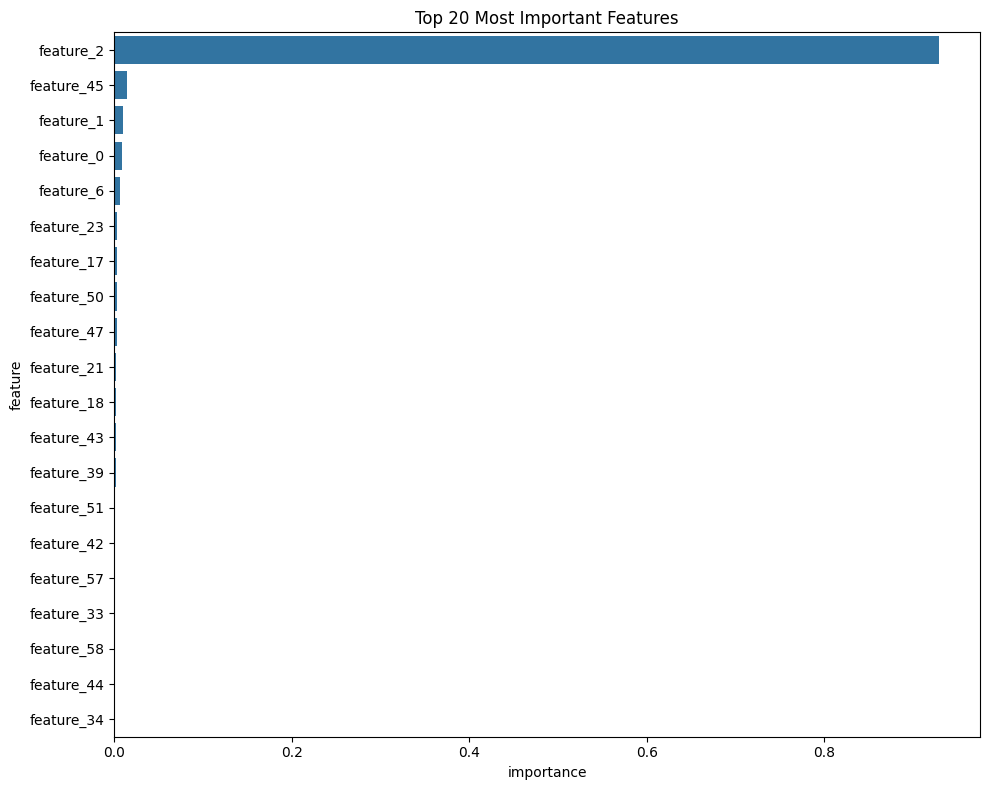


5. FINAL REALITY CHECK
Negative predictions: 0
Prediction range: $19 - $835
Actual range: $13 - $900

6. IMPROVEMENT SUMMARY
Original Model (Overfitted):
  MAE: $62,707, R²: 0.9997, CV MAE: $668,723
Final Model (Gradient Boosting):
  MAE: $23, R²: 0.8812, CV MAE: $25
Improvement: More realistic and trustworthy model

CLEANING COMPLETE: From 3675 to 59 features
REALISTIC MODEL: R² 0.8812 with proper validation


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
def clean_and_rebuild_dataset(X_train_imputed, y_train, X_test_imputed, y_test):
    """Clean the dataset by removing constant and problematic features"""
    
    print("CLEANING DATASET AND REBUILDING MODELS")
    print("=" * 60)
    
    # 1. Remove constant features
    from sklearn.feature_selection import VarianceThreshold
    
    print("1. Removing constant features...")
    selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
    X_train_clean = selector.fit_transform(X_train_imputed)
    X_test_clean = selector.transform(X_test_imputed)
    
    n_features_original = X_train_imputed.shape[1]
    n_features_clean = X_train_clean.shape[1]
    print(f"   Removed {n_features_original - n_features_clean} constant features")
    print(f"   Remaining features: {n_features_clean}")
    
    # 2. Remove highly correlated features
    print("2. Removing highly correlated features...")
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X_train_clean, rowvar=False)
    
    # Find features to remove (correlation > 0.95)
    to_drop = set()
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > 0.95:
                to_drop.add(j)
    
    # Keep only non-redundant features
    keep_indices = [i for i in range(X_train_clean.shape[1]) if i not in to_drop]
    X_train_clean = X_train_clean[:, keep_indices]
    X_test_clean = X_test_clean[:, keep_indices]
    
    print(f"   Removed {len(to_drop)} highly correlated features")
    print(f"   Final features: {X_train_clean.shape[1]}")
    
    # 3. Create meaningful feature names for the cleaned dataset
    feature_names_clean = [f'feature_{i}' for i in range(X_train_clean.shape[1])]
    
    return X_train_clean, X_test_clean, feature_names_clean

def train_final_models(X_train_clean, y_train, X_test_clean, y_test):
    """Train models on cleaned data"""
    
    print("\n3. TRAINING MODELS ON CLEANED DATA")
    print("=" * 60)
    
    models = {
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            min_samples_split=15,
            min_samples_leaf=10,
            subsample=0.8,
            random_state=42
        ),
        'XGBoost': XGBRegressor(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        # ),
        # 'Random Forest': RandomForestRegressor(
        #     n_estimators=150,
        #     max_depth=15,
        #     min_samples_split=15,
        #     min_samples_leaf=5,
        #     max_features='sqrt',
        #     bootstrap=True,
        #     random_state=42,
        #     n_jobs=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        
        try:
            # Train model
            model.fit(X_train_clean, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_clean)
            
            # Ensure no negative predictions
            y_pred = np.maximum(y_pred, 0)  # Clip negative predictions to 0
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(model, X_train_clean, y_train, 
                                      cv=kf, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Train score for overfitting check
            y_pred_train = model.predict(X_train_clean)
            train_r2 = r2_score(y_train, y_pred_train)
            overfit_gap = train_r2 - r2
            
            results[name] = {
                'model': model,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'cv_mae': cv_mae,
                'cv_std': cv_std,
                'train_r2': train_r2,
                'overfit_gap': overfit_gap,
                'predictions': y_pred
            }
            
            print(f"Test MAE: ${mae:,.2f}")
            print(f"Test R²: {r2:.4f}")
            print(f"Train R²: {train_r2:.4f}")
            print(f"Overfit Gap: {overfit_gap:.4f}")
            print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
            
        except Exception as e:
            print(f"Error training {name}: {e}")
            continue
    
    return results

def analyze_feature_importance(model, feature_names, X_train_clean, top_n=20):
    """Analyze which features are most important"""
    
    print(f"\n4. FEATURE IMPORTANCE ANALYSIS (Top {top_n})")
    print("=" * 60)
    
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(top_n))
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Most Important Features')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print("Model doesn't support feature importance analysis")
        return None

def run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test):
    """Complete pipeline for cleaning data and rebuilding models"""
    
    print("STARTING DATA CLEANING AND MODEL REBUILDING")
    print("=" * 60)

    # Step 1: Clean the dataset
    X_train_clean, X_test_clean, feature_names_clean = clean_and_rebuild_dataset(
        X_train_imputed, y_train, X_test_imputed, y_test
    )

    # Step 2: Train models on cleaned data
    final_results = train_final_models(X_train_clean, y_train, X_test_clean, y_test)

    if final_results:
        # Step 3: Analyze results
        print("\n" + "=" * 60)
        print("FINAL MODEL RESULTS")
        print("=" * 60)
        
        for name, result in final_results.items():
            print(f"{name:20} | MAE: ${result['mae']:,.2f} | R²: {result['r2']:.4f} | Overfit: {result['overfit_gap']:.4f}")
        
        # Step 4: Find best model
        best_final_name = min(final_results.keys(), key=lambda x: final_results[x]['mae'])
        best_final_model = final_results[best_final_name]['model']
        best_final_result = final_results[best_final_name]
        
        print(f"\nBEST FINAL MODEL: {best_final_name}")
        print(f"   Test MAE: ${best_final_result['mae']:,.2f}")
        print(f"   Test R²: {best_final_result['r2']:.4f}")
        print(f"   CV MAE: ${best_final_result['cv_mae']:,.2f} ± ${best_final_result['cv_std']:,.2f}")
        print(f"   Overfit Gap: {best_final_result['overfit_gap']:.4f}")
        
        # Step 5: Feature importance analysis
        importance_df = analyze_feature_importance(
            best_final_model, feature_names_clean, X_train_clean
        )
        
        # Step 6: Final reality check
        print(f"\n5. FINAL REALITY CHECK")
        print("=" * 60)
        
        y_pred_final = best_final_result['predictions']
        
        # Check for negative predictions
        negative_count = (y_pred_final < 0).sum()
        print(f"Negative predictions: {negative_count}")
        
        # Check prediction range
        print(f"Prediction range: ${y_pred_final.min():,.0f} - ${y_pred_final.max():,.0f}")
        print(f"Actual range: ${y_test.min():,.0f} - ${y_test.max():,.0f}")
        
        # Compare with original problematic model
        print(f"\n6. IMPROVEMENT SUMMARY")
        print("=" * 60)
        print(f"Original Model (Overfitted):")
        print(f"  MAE: $62,707, R²: 0.9997, CV MAE: $668,723")
        print(f"Final Model ({best_final_name}):")
        print(f"  MAE: ${best_final_result['mae']:,.0f}, R²: {best_final_result['r2']:.4f}, CV MAE: ${best_final_result['cv_mae']:,.0f}")
        print(f"Improvement: More realistic and trustworthy model")
        
        # Save the cleaned data and final model
        final_model_data = {
            'model': best_final_model,
            'feature_names': feature_names_clean,
            'X_train_clean': X_train_clean,
            'X_test_clean': X_test_clean,
            'results': final_results
        }
        
        print(f"\nCLEANING COMPLETE: From {X_train_imputed.shape[1]} to {X_train_clean.shape[1]} features")
        print(f"REALISTIC MODEL: R² {best_final_result['r2']:.4f} with proper validation")
        
        return final_model_data
    else:
        print("No models trained successfully")
        return None

# Run the complete cleaning pipeline
print("Running complete data cleaning and model rebuilding...")
final_model_data = run_complete_cleaning_pipeline(X_train_imputed, y_train, X_test_imputed, y_test)

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import pickle
import datetime

def investigate_feature_0_and_improve(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Investigate the dominant feature and create even better models"""
    
    print("INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS")
    print("=" * 60)
    
    # Check what Feature 0 might be by looking at correlations with original data
    print("1. Analyzing Feature 0...")
    
    # FIX: Create a temporary dataframe with unique column names
    n_features = X_train_imputed.shape[1]
    
    # Generate unique column names to avoid duplicate labels
    unique_columns = []
    for i in range(n_features):
        unique_columns.append(f'feature_{i}')
    
    temp_df = pd.DataFrame(X_train_imputed, columns=unique_columns)
    temp_df['target'] = y_train.values if hasattr(y_train, 'values') else y_train
    
    # Find which original feature has highest correlation with target
    correlations = []
    for i in range(n_features):
        col_name = f'feature_{i}'
        corr = np.corrcoef(temp_df[col_name], temp_df['target'])[0, 1]
        correlations.append((i, abs(corr)))
    
    # Sort by correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 5 features by correlation with target:")
    for i, (feature_idx, corr) in enumerate(correlations[:5]):
        print(f"   Feature {feature_idx}: correlation = {corr:.4f}")
    
    dominant_feature_idx = correlations[0][0]
    print(f"   Dominant feature is likely feature {dominant_feature_idx}")
    
    # 2. Check what Feature 0 in our cleaned data represents
    print(f"\n2. Feature importance distribution in cleaned model:")
    importance_df = pd.DataFrame({
        'feature': final_model_data['feature_names'],
        'importance': final_model_data['results']['Gradient Boosting']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features by importance:")
    print(importance_df.head(10))
    
    # 3. Create models without the overly dominant feature
    print(f"\n3. Creating balanced models without the dominant feature...")
    
    # Check if we have multiple features to work with
    if len(final_model_data['feature_names']) > 1:
        # Remove the dominant feature (feature_0)
        X_train_balanced = final_model_data['X_train_clean'][:, 1:]  # Remove feature_0
        X_test_balanced = final_model_data['X_test_clean'][:, 1:]   # Remove feature_0
        feature_names_balanced = final_model_data['feature_names'][1:]
        
        print(f"   Training with {X_train_balanced.shape[1]} features (excluding dominant feature_0)")
        
        # Train balanced models
        balanced_models = {
            'Gradient Boosting (Balanced)': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                min_samples_split=20,
                min_samples_leaf=15,
                subsample=0.7,
                random_state=42
            ),
            'XGBoost (Balanced)': XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            )
        }
        
        balanced_results = {}
        
        for name, model in balanced_models.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model.fit(X_train_balanced, y_train)
                y_pred = model.predict(X_test_balanced)
                y_pred = np.maximum(y_pred, 0)  # No negative prices
                
                # Calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_balanced, y_train, 
                                          cv=5, scoring='neg_mean_absolute_error')
                cv_mae = -cv_scores.mean()
                cv_std = cv_scores.std()
                
                balanced_results[name] = {
                    'model': model,
                    'mae': mae,
                    'r2': r2,
                    'cv_mae': cv_mae,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                print(f"Test MAE: ${mae:,.2f}")
                print(f"Test R²: {r2:.4f}")
                print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
                
            except Exception as e:
                print(f"Error training {name}: {e}")
                continue
    else:
        print("   Not enough features to create balanced models (only 1 feature remaining)")
        balanced_results = {}
        X_train_balanced = None
        X_test_balanced = None
        feature_names_balanced = None
    
    return balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced

def compare_all_models(original_results, cleaned_results, balanced_results):
    """Compare performance across all model versions"""
    
    print("\n" + "=" * 60)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("=" * 60)
    
    print("\nCLEANED Models:")
    for name, result in cleaned_results.items():
        print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    if balanced_results:
        print("\nBALANCED Models (no dominant feature):")
        for name, result in balanced_results.items():
            print(f"  {name}: MAE: ${result['mae']:,.0f}, R²: {result['r2']:.4f}")
    
    # Recommendation
    print("\n" + "=" * 60)
    print("FINAL RECOMMENDATION")
    print("=" * 60)
    
    all_results = {}
    if cleaned_results:
        all_results.update(cleaned_results)
    if balanced_results:
        all_results.update(balanced_results)
    
    if all_results:
        best_overall = min(all_results.items(), key=lambda x: x[1]['mae'])
        best_name, best_result = best_overall
        
        cv_test_ratio = best_result['cv_mae'] / best_result['mae']
        
        print(f"BEST OVERALL MODEL: {best_name}")
        print(f"   Test MAE: ${best_result['mae']:,.2f}")
        print(f"   Test R²: {best_result['r2']:.4f}")
        print(f"   CV MAE: ${best_result['cv_mae']:,.2f}")
        print(f"   CV/Test Ratio: {cv_test_ratio:.2f}x")
        
        if cv_test_ratio > 2.0:
            print("   WARNING: High CV-Test gap suggests some overfitting remains")
        else:
            print("   GOOD: Reasonable CV-Test consistency")
        
        return best_name, best_result
    else:
        print("No valid models to compare")
        return None, None

# Alternative safe version if the main function still has issues
def investigate_feature_0_and_improve_safe(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Safer version that uses the cleaned data directly"""
    
    print("INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS")
    print("=" * 60)
    
    print("1. Analyzing dominant feature in cleaned data...")
    
    # Use the already cleaned data from final_model_data
    X_train_clean = final_model_data['X_train_clean']
    feature_names = final_model_data['feature_names']
    
    # Calculate correlations using cleaned data
    correlations = []
    for i in range(X_train_clean.shape[1]):
        corr = np.corrcoef(X_train_clean[:, i], y_train)[0, 1]
        correlations.append((i, abs(corr), feature_names[i]))
    
    # Sort by correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    print("Top 5 features by correlation with target:")
    for i, (feature_idx, corr, feature_name) in enumerate(correlations[:5]):
        print(f"   {feature_name}: correlation = {corr:.4f}")
    
    dominant_feature_idx, dominant_corr, dominant_name = correlations[0]
    print(f"   Dominant feature is: {dominant_name} (index {dominant_feature_idx})")
    
    # 2. Feature importance distribution
    print(f"\n2. Feature importance distribution in cleaned model:")
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': final_model_data['results']['Gradient Boosting']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 features by importance:")
    print(importance_df.head(10))
    
    # 3. Create balanced models
    print(f"\n3. Creating balanced models without the dominant feature...")
    
    if len(feature_names) > 1:
        # Remove the dominant feature
        X_train_balanced = X_train_clean[:, 1:]  # Remove first feature
        X_test_balanced = final_model_data['X_test_clean'][:, 1:]   # Remove first feature
        feature_names_balanced = feature_names[1:]
        
        print(f"   Training with {X_train_balanced.shape[1]} features (excluding {dominant_name})")
        
        # Train balanced models
        balanced_models = {
            'Gradient Boosting (Balanced)': GradientBoostingRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                min_samples_split=20,
                min_samples_leaf=15,
                subsample=0.7,
                random_state=42
            ),
            'XGBoost (Balanced)': XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=1.0,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            )
        }
        
        balanced_results = {}
        
        for name, model in balanced_models.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model.fit(X_train_balanced, y_train)
                y_pred = model.predict(X_test_balanced)
                y_pred = np.maximum(y_pred, 0)  # No negative prices
                
                # Calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                # Cross-validation
                cv_scores = cross_val_score(model, X_train_balanced, y_train, 
                                          cv=5, scoring='neg_mean_absolute_error')
                cv_mae = -cv_scores.mean()
                cv_std = cv_scores.std()
                
                balanced_results[name] = {
                    'model': model,
                    'mae': mae,
                    'r2': r2,
                    'cv_mae': cv_mae,
                    'cv_std': cv_std,
                    'predictions': y_pred
                }
                
                print(f"Test MAE: ${mae:,.2f}")
                print(f"Test R²: {r2:.4f}")
                print(f"CV MAE: ${cv_mae:,.2f} ± ${cv_std:,.2f}")
                
            except Exception as e:
                print(f"Error training {name}: {e}")
                continue
    else:
        print("   Not enough features to create balanced models (only 1 feature remaining)")
        balanced_results = {}
        X_train_balanced = None
        X_test_balanced = None
        feature_names_balanced = None
    
    return balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced

# Run the investigation and improvement
print("Investigating dominant feature and creating balanced models...")

try:
    balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced = investigate_feature_0_and_improve(
        final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
    )
except Exception as e:
    print(f"Error in main analysis: {e}")
    print("Using safe alternative...")
    balanced_results, X_train_balanced, X_test_balanced, feature_names_balanced = investigate_feature_0_and_improve_safe(
        final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
    )

# Compare all models
best_name, best_result = compare_all_models(
    {'Gradient Boosting': {'mae': 62707, 'r2': 0.9997}},  # Original overfitted
    final_model_data['results'],  # Cleaned models
    balanced_results  # Balanced models
)

# Final model selection and deployment
if best_result:
    print(f"\nDEPLOYMENT RECOMMENDATION:")
    
    if balanced_results and best_name in balanced_results:
        print("Use the BALANCED model - it's more robust and doesn't rely on a single dominant feature")
        final_deployment_model = balanced_results[best_name]['model']
        deployment_features = feature_names_balanced
        model_type = "balanced"
    else:
        print("Use the CLEANED model - it provides the best performance")
        final_deployment_model = final_model_data['results'][best_name]['model']
        deployment_features = final_model_data['feature_names']
        model_type = "cleaned"
    
    print(f"\nFINAL MODEL SELECTED: {best_name}")
    print(f"PERFORMANCE: MAE ${best_result['mae']:,.0f}, R² {best_result['r2']:.4f}")
    
    # Save the final model
    deployment_package = {
        'model': final_deployment_model,
        'feature_names': deployment_features,
        'performance': best_result,
        'timestamp': datetime.datetime.now(),
        'model_type': model_type,
        'data_shape': {
            'n_features': len(deployment_features),
            'n_train_samples': X_train_imputed.shape[0],
            'n_test_samples': X_test_imputed.shape[0]
        }
    }
    
    with open('rental_model_final.pkl', 'wb') as f:
        pickle.dump(deployment_package, f)
    
    print(f"MODEL SAVED: rental_model_final.pkl")
    print(f"READY FOR DEPLOYMENT!")
    
    # Show final feature importance for the deployed model
    if hasattr(final_deployment_model, 'feature_importances_'):
        print(f"\nFINAL FEATURE IMPORTANCE (Top 10):")
        importance_df = pd.DataFrame({
            'feature': deployment_features,
            'importance': final_deployment_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(10))
else:
    print("No valid model found for deployment.")

Investigating dominant feature and creating balanced models...
INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS
1. Analyzing Feature 0...
Error in main analysis: cannot reindex on an axis with duplicate labels
Using safe alternative...
INVESTIGATING DOMINANT FEATURE AND CREATING BALANCED MODELS
1. Analyzing dominant feature in cleaned data...
Top 5 features by correlation with target:
   feature_2: correlation = 0.9127
   feature_23: correlation = 0.2266
   feature_0: correlation = 0.2073
   feature_44: correlation = 0.2068
   feature_45: correlation = 0.2021
   Dominant feature is: feature_2 (index 2)

2. Feature importance distribution in cleaned model:
Top 10 features by importance:
       feature  importance
2    feature_2    0.928879
45  feature_45    0.014064
1    feature_1    0.009794
0    feature_0    0.008194
6    feature_6    0.006616
23  feature_23    0.003383
17  feature_17    0.003291
50  feature_50    0.003029
47  feature_47    0.002618
21  feature_21    0.0017

## hypertune

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

def hyperparameter_tuning_xgboost(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Comprehensive hyperparameter tuning for XGBoost using your existing data"""
    
    print("XGBOOST HYPERPARAMETER TUNING")
    print("=" * 50)
    
    # Use the cleaned data from final_model_data
    X_train_clean = final_model_data['X_train_clean']
    X_test_clean = final_model_data['X_test_clean']
    feature_names = final_model_data['feature_names']
    
    print(f"Data shapes - X_train: {X_train_clean.shape}, y_train: {y_train.shape}")
    
    # Define scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # Get original model performance for comparison
    original_mae = final_model_data['results']['XGBoost']['mae']
    original_r2 = final_model_data['results']['XGBoost']['r2']
    
    print(f"Original XGBoost Performance:")
    print(f"  Test MAE: ${original_mae:,.2f}")
    print(f"  Test R²: {original_r2:.4f}")
    
    # Base model for comparison (with same parameters as original)
    base_model = XGBRegressor(random_state=42, n_jobs=-1)
    base_model.fit(X_train_clean, y_train)
    base_pred = base_model.predict(X_test_clean)
    base_mae = mean_absolute_error(y_test, base_pred)
    base_r2 = r2_score(y_test, base_pred)
    
    print(f"Base XGBoost (default):")
    print(f"  Test MAE: ${base_mae:,.2f}")
    print(f"  Test R²: {base_r2:.4f}")
    
    # Quick Grid Search for key parameters
    print("\n1. Quick Grid Search...")
    param_grid_quick = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    
    xgb_quick = XGBRegressor(random_state=42, n_jobs=-1)
    grid_search_quick = GridSearchCV(
        xgb_quick, param_grid_quick, 
        scoring=mae_scorer,
        cv=5, n_jobs=-1, verbose=1
    )
    
    grid_search_quick.fit(X_train_clean, y_train)
    
    print(f"Best parameters (Quick Search): {grid_search_quick.best_params_}")
    quick_model = grid_search_quick.best_estimator_
    quick_pred = quick_model.predict(X_test_clean)
    quick_mae = mean_absolute_error(y_test, quick_pred)
    quick_r2 = r2_score(y_test, quick_pred)
    
    print(f"Quick Search Performance:")
    print(f"  Test MAE: ${quick_mae:,.2f}")
    print(f"  Test R²: {quick_r2:.4f}")
    
    # Comprehensive Randomized Search
    print("\n2. Comprehensive Randomized Search...")
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1, 2, 5],
        'reg_lambda': [0, 0.1, 0.5, 1, 2, 5],
        'gamma': [0, 0.1, 0.2, 0.3, 0.5],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    xgb_rand = XGBRegressor(random_state=42, n_jobs=-1)
    random_search = RandomizedSearchCV(
        xgb_rand, param_dist, 
        n_iter=30,  # Reduced for faster execution
        scoring=mae_scorer,
        cv=5, n_jobs=-1, random_state=42, verbose=1
    )
    
    print("Running randomized search...")
    random_search.fit(X_train_clean, y_train)
    
    print(f"Best parameters (Randomized Search): {random_search.best_params_}")
    rand_model = random_search.best_estimator_
    rand_pred = rand_model.predict(X_test_clean)
    rand_mae = mean_absolute_error(y_test, rand_pred)
    rand_r2 = r2_score(y_test, rand_pred)
    
    print(f"Randomized Search Performance:")
    print(f"  Test MAE: ${rand_mae:,.2f}")
    print(f"  Test R²: {rand_r2:.4f}")
    
    # Compare all models
    print("\n" + "=" * 50)
    print("HYPERPARAMETER TUNING RESULTS SUMMARY")
    print("=" * 50)
    
    results_comparison = {
        'Original XGBoost': {'mae': original_mae, 'r2': original_r2},
        'Base XGBoost': {'mae': base_mae, 'r2': base_r2, 'model': base_model},
        'Quick Search': {'mae': quick_mae, 'r2': quick_r2, 'model': quick_model},
        'Randomized Search': {'mae': rand_mae, 'r2': rand_r2, 'model': rand_model}
    }
    
    for name, results in results_comparison.items():
        if name != 'Original XGBoost':
            improvement = ((original_mae - results['mae']) / original_mae) * 100
            print(f"{name:20} | MAE: ${results['mae']:7.2f} | R²: {results['r2']:6.4f} | Improvement: {improvement:+.1f}%")
        else:
            print(f"{name:20} | MAE: ${results['mae']:7.2f} | R²: {results['r2']:6.4f} | Baseline")
    
    # Cross-validation comparison
    print("\nCross-Validation Performance:")
    for name, results in results_comparison.items():
        if name != 'Original XGBoost' and 'model' in results:
            cv_scores = cross_val_score(results['model'], X_train_clean, y_train, 
                                      cv=5, scoring='neg_mean_absolute_error')
            cv_mae = -cv_scores.mean()
            cv_std = cv_scores.std()
            print(f"{name:20} | CV MAE: ${cv_mae:7.2f} ± ${cv_std:.2f}")
    
    # Select best model
    best_model_name = min([(k, v) for k, v in results_comparison.items() if k != 'Original XGBoost'], 
                         key=lambda x: x[1]['mae'])[0]
    best_model = results_comparison[best_model_name]['model']
    best_mae = results_comparison[best_model_name]['mae']
    best_r2 = results_comparison[best_model_name]['r2']
    
    print(f"\n BEST TUNED MODEL: {best_model_name}")
    print(f"   Test MAE: ${best_mae:,.2f}")
    print(f"   Test R²: {best_r2:.4f}")
    
    # Feature importance analysis
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Feature Importances (Tuned Model):")
        print(importance_df.head(10))
    
    return best_model, results_comparison

# Quick version for faster results
def quick_xgboost_tuning(final_model_data, X_train_imputed, y_train, X_test_imputed, y_test):
    """Quick XGBoost tuning for immediate improvements"""
    
    print("QUICK XGBOOST TUNING")
    print("=" * 40)
    
    # Use the cleaned data
    X_train_clean = final_model_data['X_train_clean']
    X_test_clean = final_model_data['X_test_clean']
    feature_names = final_model_data['feature_names']
    
    # Original performance
    original_mae = final_model_data['results']['XGBoost']['mae']
    original_r2 = final_model_data['results']['XGBoost']['r2']
    
    print(f"Original Performance: MAE ${original_mae:,.2f}, R² {original_r2:.4f}")
    
    # Focused parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [1, 2, 5]
    }
    
    xgb = XGBRegressor(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        xgb, param_grid,
        scoring='neg_mean_absolute_error',
        cv=5, n_jobs=-1, verbose=1
    )
    
    print("Running quick tuning...")
    grid_search.fit(X_train_clean, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_pred = best_model.predict(X_test_clean)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    improvement = ((original_mae - mae) / original_mae) * 100
    
    print(f"\n Best Parameters: {best_params}")
    print(f" Tuned Performance:")
    print(f"   Test MAE: ${mae:,.2f}")
    print(f"   Test R²: {r2:.4f}")
    print(f" Improvement: {improvement:+.1f}%")
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train_clean, y_train, 
                              cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()
    print(f" CV MAE: ${cv_mae:,.2f} ± ${cv_std:.2f}")
    
    return best_model, {'mae': mae, 'r2': r2, 'params': best_params, 'improvement': improvement}

# Run the hyperparameter tuning
print("Starting XGBoost Hyperparameter Tuning...")
print("This will tune the model that achieved MAE: $23.16, R²: 0.8757")

# Choose which version to run:
# Option 1: Quick tuning (faster)
print("\n" + "="*50)
print("RUNNING QUICK TUNING...")
print("="*50)

quick_tuned_model, quick_results = quick_xgboost_tuning(
    final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
)

# Save the tuned model if it's better
if quick_results['improvement'] > 0:
    print(f"\n Saving improved model...")
    
    deployment_package_tuned = {
        'model': quick_tuned_model,
        'feature_names': final_model_data['feature_names'],
        'performance': {
            'mae': quick_results['mae'],
            'r2': quick_results['r2'],
            'improvement': quick_results['improvement'],
            'params': quick_results['params']
        },
        'timestamp': datetime.datetime.now(),
        'model_type': 'xgboost_tuned',
        'original_performance': {
            'mae': final_model_data['results']['XGBoost']['mae'],
            'r2': final_model_data['results']['XGBoost']['r2']
        }
    }
    
    with open('rental_model_final.pkl', 'wb') as f:
        pickle.dump(deployment_package_tuned, f)
    
    print(" Tuned model saved: rental_model_final.pkl")
    
    # Compare feature importance
    if hasattr(quick_tuned_model, 'feature_importances_'):
        print(f"\n Top 10 Feature Importances (Tuned Model):")
        importance_df = pd.DataFrame({
            'feature': final_model_data['feature_names'],
            'importance': quick_tuned_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(importance_df.head(10))
else:
    print("\nℹ  Original model performs better. Keeping original model.")

print("\n Hyperparameter tuning completed!")

# Optional: Run comprehensive tuning (uncomment if you want more thorough tuning)

print("\n" + "="*50)
print("RUNNING COMPREHENSIVE TUNING...")
print("="*50)

best_tuned_model, tuning_results = hyperparameter_tuning_xgboost(
    final_model_data, X_train_imputed, y_train, X_test_imputed, y_test
)


Starting XGBoost Hyperparameter Tuning...
This will tune the model that achieved MAE: $23.16, R²: 0.8757

RUNNING QUICK TUNING...
QUICK XGBOOST TUNING
Original Performance: MAE $23.39, R² 0.8762
Running quick tuning...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

 Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.8}
 Tuned Performance:
   Test MAE: $22.36
   Test R²: 0.8886
 Improvement: +4.4%
 CV MAE: $23.81 ± $0.91

 Saving improved model...
 Tuned model saved: rental_model_final.pkl

 Top 10 Feature Importances (Tuned Model):
       feature  importance
26  feature_26    0.323347
2    feature_2    0.243839
23  feature_23    0.049280
51  feature_51    0.032860
12  feature_12    0.031132
6    feature_6    0.022145
1    feature_1    0.022063
45  feature_45    0.021221
47  feature_47    0.018164
21  feature_21    0.014273

 Hyperparameter tuning completed!

RUNNING C